In [1]:
import os, random, time
import xgboost
import datetime
import pygam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import r2_score
print(os.getcwd())

Importing plotly failed. Interactive plots will not work.


/rapids/GSCM/ES


In [2]:
y_inven = pd.read_csv('./data/Y_Inven_210506.csv')
x_sales = pd.read_csv('./data/X_Sales_210506.csv')
x_product = pd.read_csv('./data/X_Product_210506.csv')

In [3]:
def dataset(x_dta, case=1, is_train=True):
    x_prev_col = [s for s in x_dta.columns.values if 'Prev' in s]
    x_post_col = [s for s in x_dta.columns.values if 'Post' in s]
    x_var_col = [s for s in x_dta.columns.values if 'Var' in s]

    X_prev_ = x_dta[x_prev_col]
    X_post_ = x_dta[x_post_col]
    X_var_ = x_dta[x_var_col]
    if case ==1 :
        Y_ =  x_dta['Sales']
    else :
        Y_ =  x_dta['Products']

    if is_train :
        X_prev_train = X_prev_[x_dta['YEAR']==2020]
        X_post_train = X_post_[x_dta['YEAR']==2020]
        X_var_train = X_var_[x_dta['YEAR']==2020]
        Y_train = Y_[x_dta['YEAR']==2020]
    else:
        X_prev_train = X_prev_[x_dta['YEAR']==2021]
        X_post_train = X_post_[x_dta['YEAR']==2021]
        X_var_train = X_var_[x_dta['YEAR']==2021]
        Y_train = Y_[x_dta['YEAR']==2021]
    
    return Y_train, X_prev_train, X_post_train, X_var_train    

def run_model_(model_, trX_, trY_, teX_, teY_):
    model_.fit(trX_, trY_)
    hat_prev_ = model_.predict(trX_)
    hat_  = model_.predict(teX_)
    Y_hat_ = np.concatenate((hat_prev_, hat_))
    Y_     = np.concatenate((trY_, teY_))
    real_ = np.mean(1- np.abs(trY_ - hat_prev_) / np.abs(trY_)) * 100
    fcst_ = np.mean(1- np.abs(teY_ - hat_     ) / np.abs(teY_)) * 100    
    return real_, fcst_, Y_hat_, Y_, hat_prev_, hat_

In [4]:
# Y_sales_train, sales_prev_X_train, sales_post_X_train, sales_var_X_train = dataset(x_sales, 1)
# Y_sales_test , sales_prev_X_test , sales_post_X_test , sales_var_X_test  = dataset(x_sales, 1, False)
# Y_products_train, products_prev_X_train, products_post_X_train, products_var_X_train = dataset(x_product, 2)
# Y_products_test , products_prev_X_test , products_post_X_test , products_var_X_test  = dataset(x_product, 2, False)
# sales_weight = list(map(lambda x : 0.9531**x if x > 0 else 1, range(0,12)))
# product_weight = list(map(lambda x : 0.9714**x if x > 0 else 1, range(0,12)))

In [5]:
sales_weight = list(map(lambda x : 0.9531**x if x > 0 else 1, range(0,12)))
product_weight = list(map(lambda x : 0.9714**x if x > 0 else 1, range(0,12)))

Y_sales_train = x_sales.iloc[:43,38:39]
Y_sales_train = pd.Series(Y_sales_train["Sales"])
sales_prev_X_train = x_sales.iloc[:43,0:12]
sales_post_X_train = x_sales.iloc[:43,12:24]
sales_var_X_train = x_sales.iloc[:43,24:36]

Y_sales_test = x_sales.iloc[43:55,38:39]
Y_sales_test = pd.Series(Y_sales_test["Sales"])
sales_prev_X_test = x_sales.iloc[43:55,0:12]
sales_post_X_test = x_sales.iloc[43:55,12:24]
sales_var_X_test = x_sales.iloc[43:55,24:36]

Y_products_train = x_product.iloc[:43,38:39]
Y_products_train = pd.Series(Y_products_train["Products"])
products_prev_X_train = x_product.iloc[:43,0:12]
products_post_X_train = x_product.iloc[:43,12:24]
products_var_X_train = x_product.iloc[:43,24:36]

Y_products_test = x_product.iloc[43:55,38:39]
Y_products_test = pd.Series(Y_products_test["Products"])
products_prev_X_test = x_product.iloc[43:55,0:12]
products_post_X_test = x_product.iloc[43:55,12:24]
products_var_X_test = x_product.iloc[43:55,24:36]

In [6]:
#sales_var_X_train
sales_var_X_train1 = np.multiply(sales_var_X_train, np.tile([sales_weight], sales_var_X_train.shape[0]).reshape(sales_var_X_train.shape[0], -1)).copy()
sales_var_X_test1 = np.multiply(sales_var_X_test, np.tile([sales_weight], sales_var_X_test.shape[0]).reshape(sales_var_X_test.shape[0], -1)).copy()
products_var_X_train1 = np.multiply(products_var_X_train, np.tile([product_weight], products_var_X_train.shape[0]).reshape(products_var_X_train.shape[0], -1)).copy()
products_var_X_test1 = np.multiply(products_var_X_test, np.tile([product_weight], products_var_X_test.shape[0]).reshape(products_var_X_test.shape[0], -1)).copy()

In [7]:
##    iter    |  target   |   alpha   |   col_k   |   m_lr    | m_max_... | m_n_es... | m_subs... |
##  55       |  90.38    |  0.9526   |  4.938    |  0.06102  |  9.038    |  68.36    |  0.3951   |
model_sales=xgboost.XGBRegressor(n_estimators=68, learning_rate=0.2699, gamma=0, subsample=0.7334, colsample_bytree=1, max_depth=4)#, tree_method='gpu_hist', gpu_id=0)

##   24       |  89.73    |  0.9778   |  2.284    |  0.1653   |  2.388    |  90.34    |  0.4241   |
model_products=xgboost.XGBRegressor(n_estimators=43, learning_rate=0.1782, gamma=0, subsample=0.3165, colsample_bytree=1, max_depth=9)#, tree_method='gpu_hist', gpu_id=0)

In [8]:
sales_var_col = [s for s in sales_var_X_train.columns.values if 'Var' in s]
product_var_col = [s for s in products_var_X_train.columns.values if 'Var' in s]

In [9]:
real_sale, fcst_sale, sales_Y_, sales_Y_hat_, sales_prev, sales_hat = run_model_(model_sales, 
                                                                                 sales_var_X_train1[sales_var_col[:4]], Y_sales_train,
                                                                                 sales_var_X_test1[sales_var_col[:4]], Y_sales_test)
print(" Sales Mean Average => Train :  %f5 / Test : %f5"%(real_sale, fcst_sale))

 Sales Mean Average => Train :  98.5269425 / Test : 72.1217255


In [10]:
real_product, fcst_product, products_Y_, products_Y_hat_, products_prev, products_hat = run_model_(model_products, 
                                                                                                   products_var_X_train1[product_var_col[:5]], Y_products_train,
                                                                                                   products_var_X_test1[product_var_col[:5]], Y_products_test)
print(" Sales Mean Average => Train :  %f5 / Test : %f5"%(real_product, fcst_product))

 Sales Mean Average => Train :  -245.3111425 / Test : 85.7614995


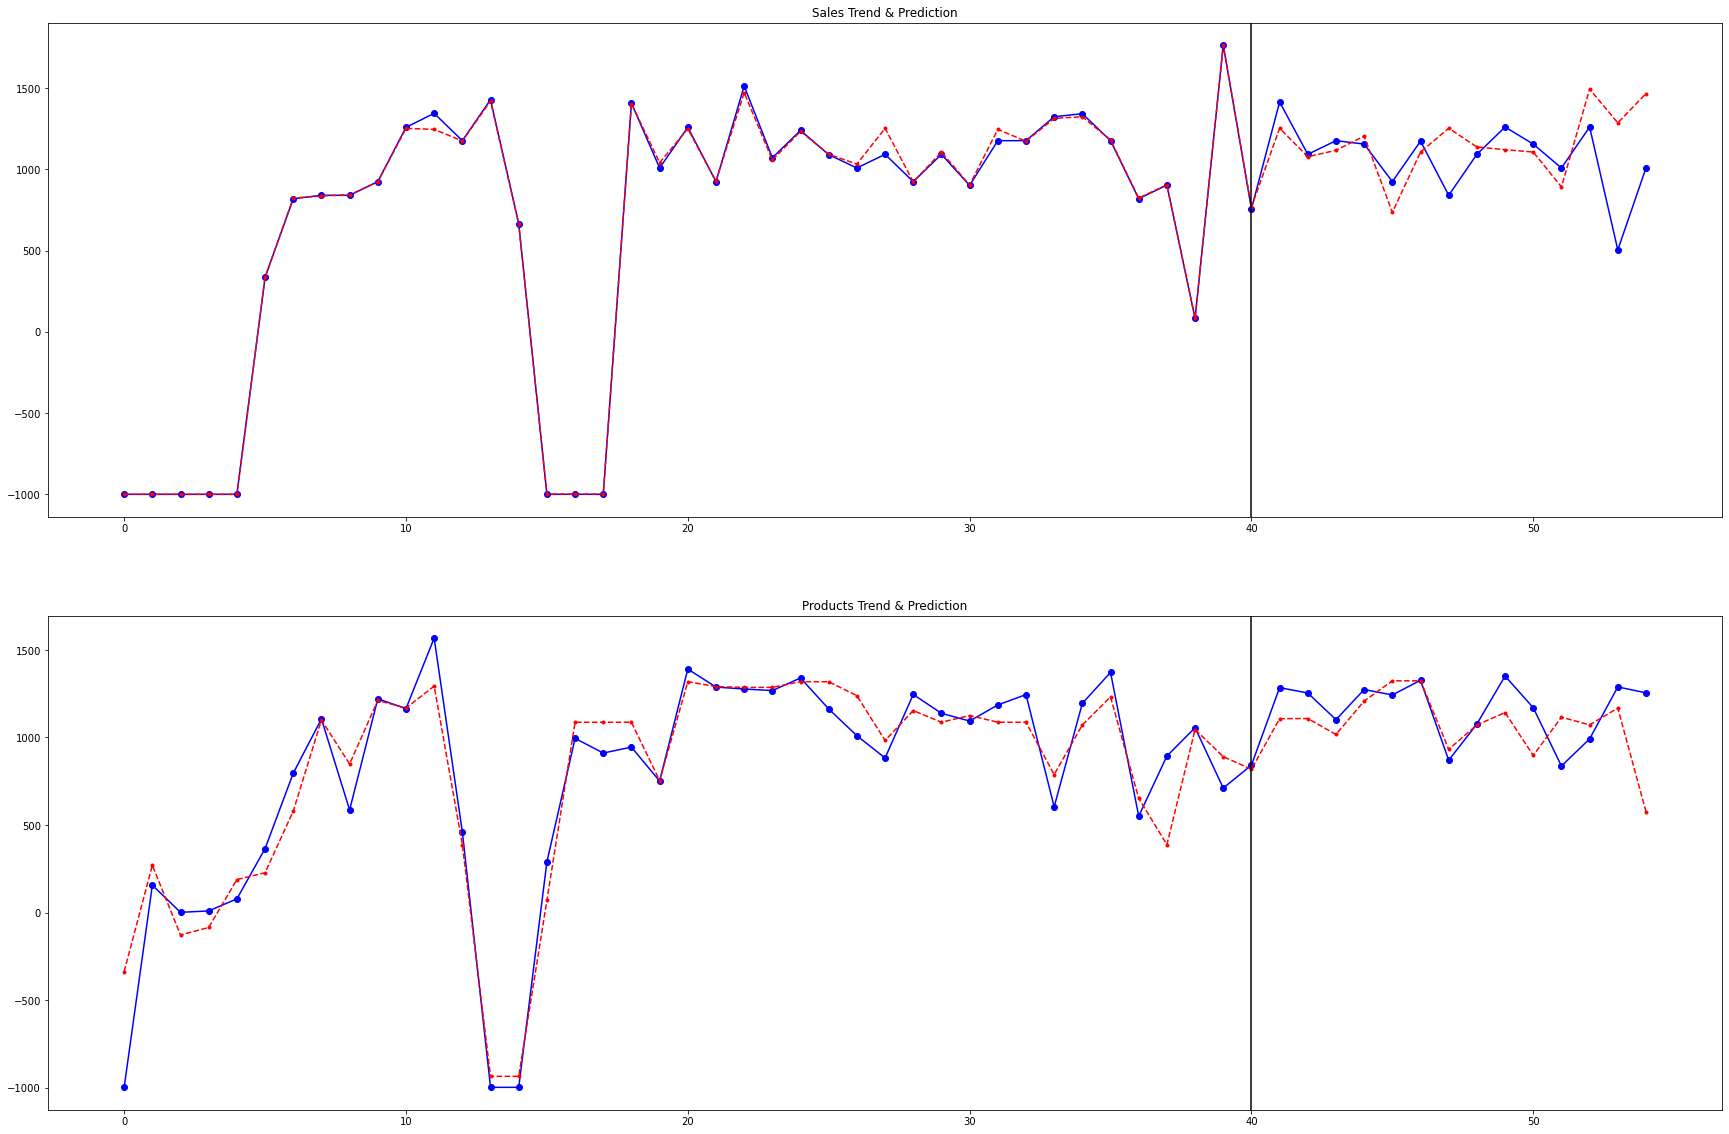

In [11]:
# plt.figure(figsize=(30,20))
# plt.subplot(2,1,1)
# plt.title("Sales Trend & Prediction")
# plt.plot(sales_Y_, color='blue', marker='o')
# plt.plot(sales_Y_hat_, color='red', linestyle='dashed', marker='.')
# plt.axvline(40, c='k')
# plt.subplot(2,1,2)
# plt.title("Products Trend & Prediction")
# plt.plot(products_Y_, color='blue', marker='o')
# plt.plot(products_Y_hat_, color='red', linestyle='dashed', marker='.')
# plt.axvline(40, c='k')

plt.figure(figsize=(30,20))
plt.subplot(2,1,1)
plt.title("Sales Trend & Prediction")
plt.plot(sales_Y_hat_, color='blue', marker='o')
plt.plot(sales_Y_, color='red', linestyle='dashed', marker='.')
plt.axvline(40, c='k')
plt.subplot(2,1,2)
plt.title("Products Trend & Prediction")
plt.plot(products_Y_hat_, color='blue', marker='o')
plt.plot(products_Y_, color='red', linestyle='dashed', marker='.')
plt.axvline(40, c='k')

In [12]:
# y_inven_train = y_inven[y_inven['YEAR']==2020]
y_inven_train = y_inven.iloc[0:47]
# y_inven_test = y_inven[y_inven['YEAR']==2021]
y_inven_test = y_inven.iloc[47:59]

products_prev_x_test_hat = pd.concat([products_prev_X_test.iloc[:12].reset_index(drop=True), pd.DataFrame(products_hat[:12])], 1).copy()
for i in range(products_prev_x_test_hat.shape[0]):
    tmp_prod_hat = products_prev_x_test_hat.iloc[i, -1]
    for j in range(0, 12):
        if i+j+1 < products_prev_x_test_hat.shape[0]:
            products_prev_x_test_hat.iloc[i+j+1, j ] = tmp_prod_hat

In [13]:
dta_train = pd.concat([y_inven_train.iloc[1:, :], y_inven_test.iloc[:1, :]]).copy().reset_index(drop=True)
dta_train['Sales'] = Y_sales_train
dta_train = pd.concat([dta_train, products_prev_X_train], axis=1).copy()
dta_train['Product'] = Y_products_train
#dta_train = pd.concat([dta_train, products_prev_X_train], axis=1)

dta_test = y_inven_test.iloc[0:,:].copy()
dta_test['Sales'] = sales_hat[:12]
dta_test = pd.concat([dta_test.reset_index(drop=True), products_prev_x_test_hat.iloc[:,:-1]], axis=1).copy()
dta_test['Product'] = products_hat[:12]

 Real Inventory Mean Average : 92.7565885
 Forecst Inventory Mean Average : 78.2965465


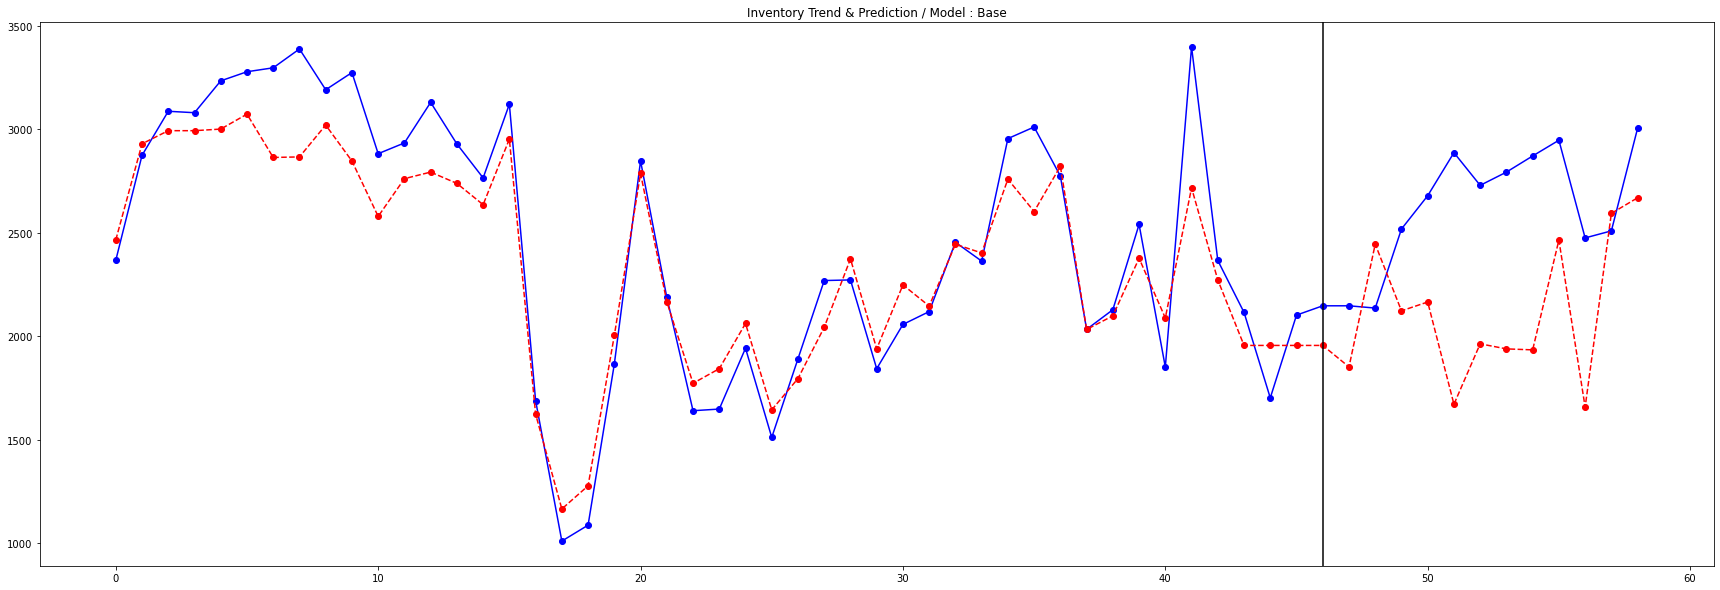

In [14]:
############################
####### Base Model #########
############################

train_col_name = list(['Sales', 'Product'])#+prev_inven_col[:1]list(['Prev_Product_2'])#
model_inven=xgboost.XGBRegressor(n_estimators=50, learning_rate=0.08, gamma=0, subsample=0.7, colsample_bytree=1, max_depth=7)

model_inven.fit(dta_train[train_col_name], dta_train['INVENTORY'])
inven_prev = model_inven.predict(dta_train[train_col_name])
inven_hat = model_inven.predict(dta_test[train_col_name])
Y_inven_hat = np.concatenate((inven_prev, inven_hat))
Y_inven = np.concatenate((dta_train['INVENTORY'], dta_test['INVENTORY']))

real_avg = np.mean(1- np.abs(dta_train['INVENTORY'] - inven_prev) / dta_train['INVENTORY']) * 100
fcst_avg = np.mean(1- np.abs(dta_test['INVENTORY'] - inven_hat) / dta_test['INVENTORY']) * 100

print(" Real Inventory Mean Average : %f5"%(real_avg))
print(" Forecst Inventory Mean Average : %f5"%(fcst_avg))

plt.figure(figsize=(30,10))
plt.title("Inventory Trend & Prediction / Model : Base")
plt.plot(Y_inven, color='blue', marker='o')
plt.plot(Y_inven_hat, color='red', linestyle='dashed', marker='o')
plt.axvline(len(inven_prev)-1, c='k')

Hyper Parameters : 
1 2
67 0.5 0.77 5
################################################
 Real Inventory Mean Average : 99.9995925
 Forecst Inventory Mean Average : 72.6525515


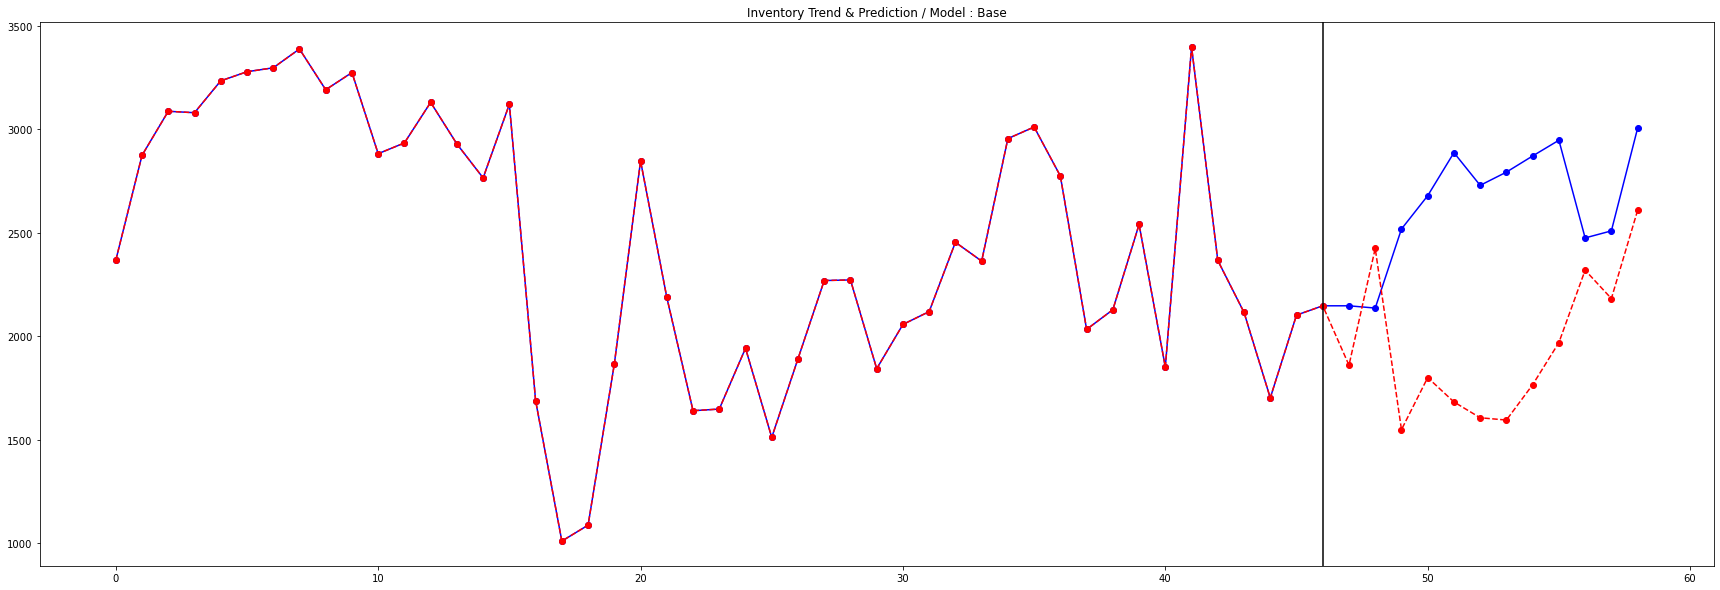

In [15]:
### |   iter    |  target   |  col_k1   |  col_k2   |   m_lr    | m_max_... | m_n_es... | m_subs... |
### |  75       |  92.53    |  0.6479   |  1.956    |  0.5      |  5.485    |  67.09    |  0.767    |

i_col, p_col = round(0.6479), round(1.956)
p_m_n_estimator, p_m_lr, p_m_sub, p_m_max_dep = round(67.09), round(0.5, 2), round(0.767, 2), round(5.485)
print("Hyper Parameters : ")
print(i_col, p_col)
print(p_m_n_estimator, p_m_lr, p_m_sub, p_m_max_dep)
print("################################################")


prev_inven_col   = [s for s in dta_test.columns.values if 'prev_INVENTORY' in s]
prev_product_col = [s for s in dta_test.columns.values if 'Prev_Product' in s]
train_col_name = list(['Sales', 'Product'])+prev_inven_col[:i_col]+prev_product_col[:p_col]
model_inven=xgboost.XGBRegressor(n_estimators=p_m_n_estimator, learning_rate=p_m_lr, gamma=0, subsample=p_m_sub, colsample_bytree=1, max_depth=p_m_max_dep)

model_inven.fit(dta_train[train_col_name], dta_train['INVENTORY'])
inven_prev = model_inven.predict(dta_train[train_col_name])

inven_hat = [] 
for i in range(0, dta_test.shape[0]):
    test_default_x = dta_test[['Sales', 'Product']].iloc[i:(i+1),:]
    test_prev_inven_x = dta_test[prev_inven_col[:i_col]].iloc[i:(i+1),:]
    test_prev_product_x = dta_test[prev_product_col[:p_col]].iloc[i:(i+1),:]
    
    if i > 0 :        
        for j in range(0, i_col):
            if j < len(inven_hat):
                test_prev_inven_x.iloc[:1,j] = inven_hat[(len(inven_hat)-j-1)]
                                  
    test_x = pd.concat([test_default_x, test_prev_inven_x, test_prev_product_x], 1)                              
    inven_hat.append(model_inven.predict(test_x)[0])

Y_inven_hat = np.concatenate((inven_prev, inven_hat))
Y_inven = np.concatenate((dta_train['INVENTORY'], dta_test['INVENTORY']))

real_avg = np.mean(1- np.abs(dta_train['INVENTORY'] - inven_prev) / dta_train['INVENTORY']) * 100
fcst_avg = np.mean(1- np.abs(dta_test['INVENTORY'] - inven_hat) / dta_test['INVENTORY']) * 100

print(" Real Inventory Mean Average : %f5"%(real_avg))
print(" Forecst Inventory Mean Average : %f5"%(fcst_avg))

plt.figure(figsize=(30,10))
plt.title("Inventory Trend & Prediction / Model : Base")
plt.plot(Y_inven, color='blue', marker='o')
plt.plot(Y_inven_hat, color='red', linestyle='dashed', marker='o')
plt.axvline(len(inven_prev)-1, c='k')    

 Real Inventory Mean Average : 98.8575515
 Forecst Inventory Mean Average : 71.6664595


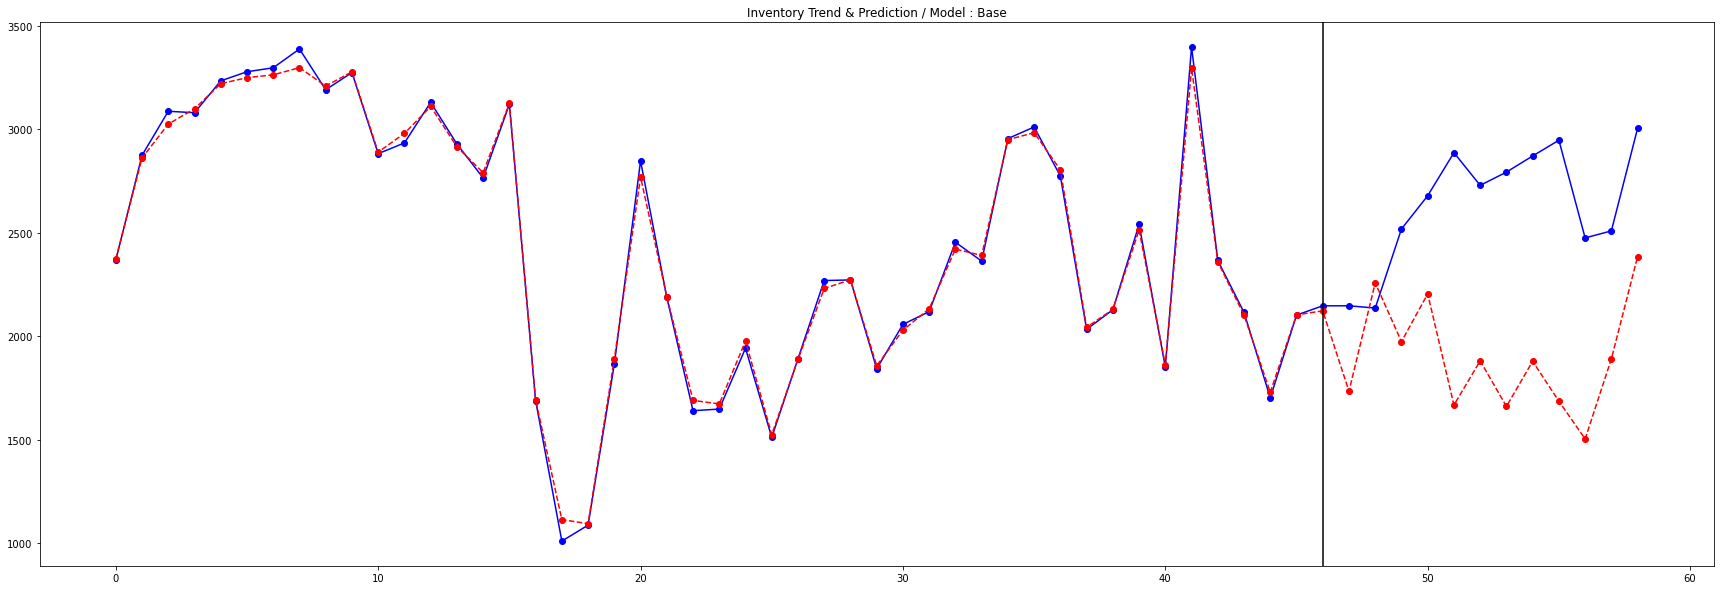

In [16]:
#######################
####### Model 1 #######
#######################
prev_inven_col = [s for s in dta_train.columns.values if 'prev_INVENTORY' in s]
train_col_name = list(['Sales', 'Product'])+prev_inven_col[1:2]
model_inven=xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.7, colsample_bytree=1, max_depth=7)

model_inven.fit(dta_train[train_col_name], dta_train['INVENTORY'])
inven_prev = model_inven.predict(dta_train[train_col_name])
inven_hat = np.zeros(dta_test.shape[0])
for i in range(0, dta_test.shape[0]):
    if i < 2 :
        tmp_x = pd.DataFrame({ 'Sales' : [dta_test['Sales'].iloc[i]], 'Product' : [dta_test['Product'].iloc[i]],
                              str(prev_inven_col[1:2][0]) : dta_test[prev_inven_col[1:2]].iloc[i,:].values})
    else :
        tmp_x = pd.DataFrame({ 'Sales' : [dta_test['Sales'].iloc[i]], 'Product' : [dta_test['Product'].iloc[i]],
                              str(prev_inven_col[1:2][0]) : inven_hat[i-2]})        
    inven_hat[i] = model_inven.predict(tmp_x)
    
#inven_hat = model_inven.predict(dta_test[train_col_name])
Y_inven_hat = np.concatenate((inven_prev, inven_hat))
Y_inven = np.concatenate((dta_train['INVENTORY'], dta_test['INVENTORY']))

real_avg = np.mean(1- np.abs(dta_train['INVENTORY'] - inven_prev) / dta_train['INVENTORY']) * 100
fcst_avg = np.mean(1- np.abs(dta_test['INVENTORY'] - inven_hat) / dta_test['INVENTORY']) * 100

print(" Real Inventory Mean Average : %f5"%(real_avg))
print(" Forecst Inventory Mean Average : %f5"%(fcst_avg))

plt.figure(figsize=(30,10))
plt.title("Inventory Trend & Prediction / Model : Base")
plt.plot(Y_inven, color='blue', marker='o')
plt.plot(Y_inven_hat, color='red', linestyle='dashed', marker='o')
plt.axvline(len(inven_prev)-1, c='k')

 Real Inventory Mean Average : 95.6338675
 Forecst Inventory Mean Average : 86.9159875


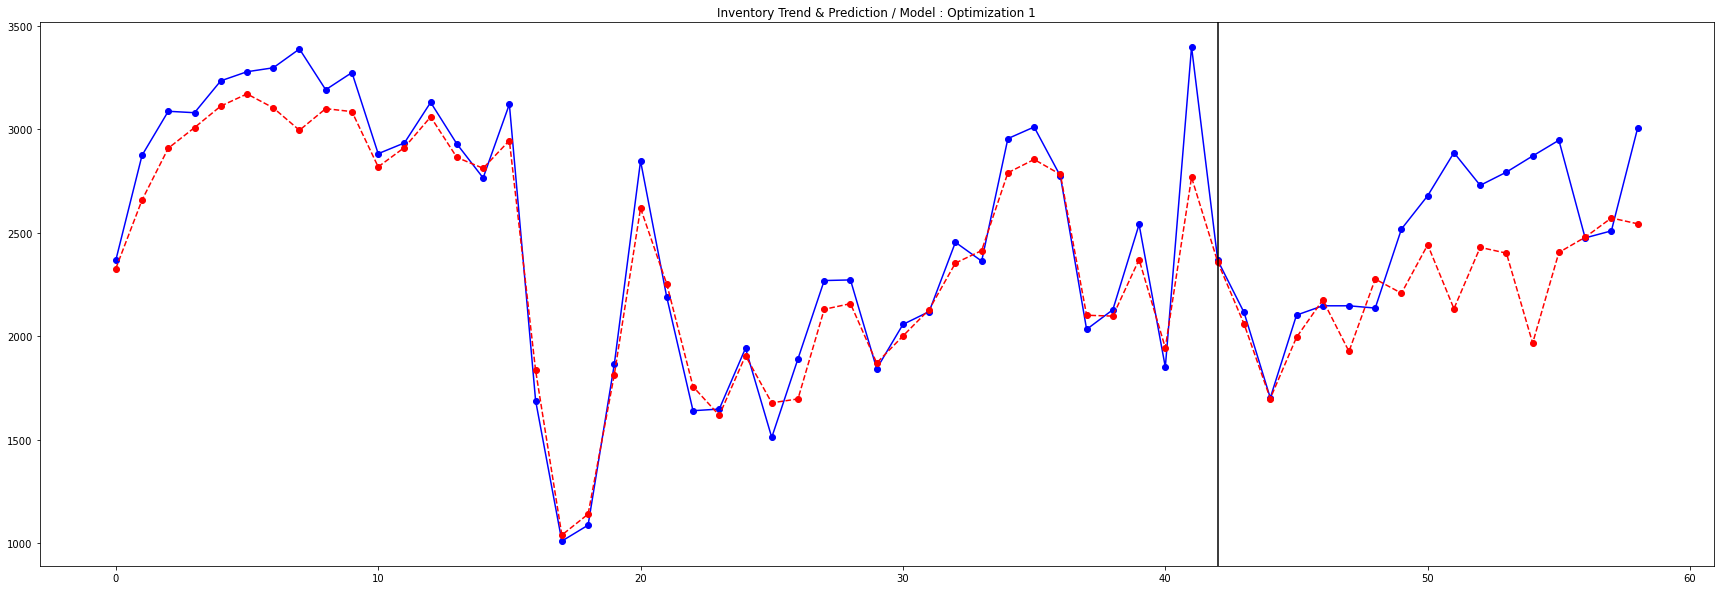

In [17]:
#######################
####### Model Optimization 1 #######
#######################
prev_inven_col = [s for s in dta_train.columns.values if 'prev_INVENTORY' in s]

p_alpha = round(0.965, 3)
p_col = round(3.741)
p_m_n_estimator = round(62.19)
p_m_lr = round(0.2699, 2)
p_m_sub = round(0.7334, 2)
p_m_max_dep = round(3.981)

weight_mat = list(map(lambda x : p_alpha**x if x > 0 else 1, range(0, p_col)))
dta_train1 = dta_train.copy()
dta_train1[prev_inven_col[:p_col]] = np.multiply(dta_train[prev_inven_col[:p_col]], np.tile([weight_mat], dta_train.shape[0]).reshape(dta_train.shape[0], -1))
dta_test1 = dta_test.copy()
dta_test1[prev_inven_col[:p_col]] = np.multiply(dta_test[prev_inven_col[:p_col]], np.tile([weight_mat], dta_test.shape[0]).reshape(dta_test.shape[0], -1))
train_col_name = list(['Sales', 'Product'])+prev_inven_col[:3]

model_inven=xgboost.XGBRegressor(n_estimators=50, learning_rate=0.08, gamma=0, subsample=0.7, colsample_bytree=1, max_depth=7)

model_inven.fit(dta_train1[train_col_name], dta_train1['INVENTORY'])
inven_prev = model_inven.predict(dta_train1[train_col_name])    
inven_hat = model_inven.predict(dta_test1[train_col_name])
Y_inven_hat = np.concatenate((inven_prev, inven_hat))
Y_inven = np.concatenate((dta_train1['INVENTORY'], dta_test1['INVENTORY']))

real_avg = np.mean(1- np.abs(dta_train1['INVENTORY'] - inven_prev) / dta_train1['INVENTORY']) * 100
fcst_avg = np.mean(1- np.abs(dta_test1['INVENTORY'] - inven_hat) / dta_test1['INVENTORY']) * 100

print(" Real Inventory Mean Average : %f5"%(real_avg))
print(" Forecst Inventory Mean Average : %f5"%(fcst_avg))

plt.figure(figsize=(30,10))
plt.title("Inventory Trend & Prediction / Model : Optimization 1")
plt.plot(Y_inven, color='blue', marker='o')
plt.plot(Y_inven_hat, color='red', linestyle='dashed', marker='o')
plt.axvline(42, c='k')

Hyper Parameters : 
3 5
88 0.5 0.9 7
################################################
 Real Inventory Mean Average : 99.9999855
 Forecst Inventory Mean Average : 82.3884885


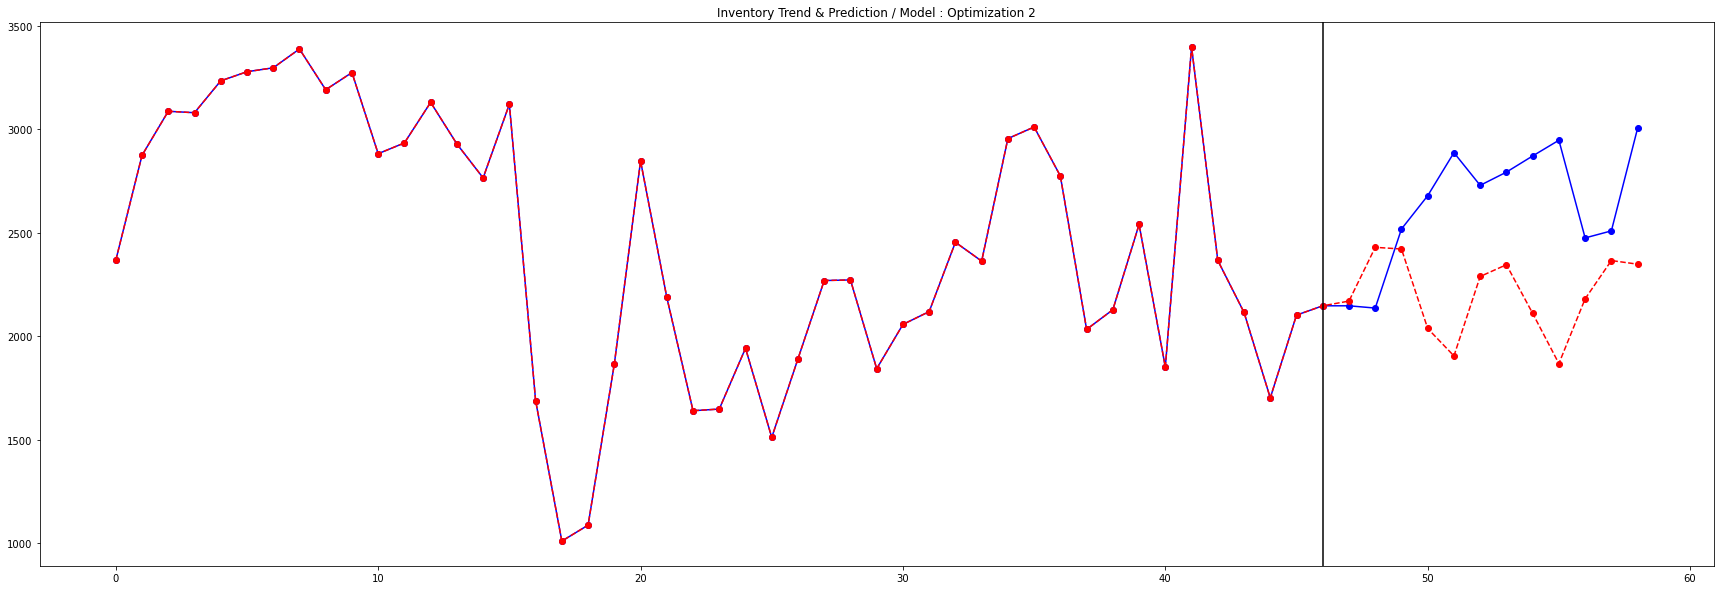

In [18]:
#######################
####### Model Optimization 2 #######
#######################


### |   iter    |  target   |  col_k1   |  col_k2   |   m_lr    | m_max_... | m_n_es... | m_subs... |
### |  75       |  92.53    |  3.422    |  4.77     |  0.5      |  7.383    |  88.44    |  0.9    |

i_col, p_col = round(3.422), round(4.77)
p_m_n_estimator, p_m_lr, p_m_sub, p_m_max_dep = round(88.44), round(0.5, 2), round(0.9, 2), round(7.383)
print("Hyper Parameters : ")
print(i_col, p_col)
print(p_m_n_estimator, p_m_lr, p_m_sub, p_m_max_dep)
print("################################################")


prev_inven_col   = [s for s in dta_test.columns.values if 'prev_INVENTORY' in s]
prev_product_col = [s for s in dta_test.columns.values if 'Prev_Product' in s]
train_col_name = list(['Sales', 'Product'])+prev_inven_col[:i_col]+prev_product_col[:p_col]
model_inven=xgboost.XGBRegressor(n_estimators=p_m_n_estimator, learning_rate=p_m_lr, gamma=0, subsample=p_m_sub, colsample_bytree=1, max_depth=p_m_max_dep)

model_inven.fit(dta_train[train_col_name], dta_train['INVENTORY'])
inven_prev = model_inven.predict(dta_train[train_col_name])

inven_hat = [] 
for i in range(0, dta_test.shape[0]):
    test_default_x = dta_test[['Sales', 'Product']].iloc[i:(i+1),:]
    test_prev_inven_x = dta_test[prev_inven_col[:i_col]].iloc[i:(i+1),:]
    test_prev_product_x = dta_test[prev_product_col[:p_col]].iloc[i:(i+1),:]
    
    if i > 0 :        
        for j in range(0, i_col):
            if j < len(inven_hat):
                test_prev_inven_x.iloc[:1,j] = inven_hat[(len(inven_hat)-j-1)]
                                  
    test_x = pd.concat([test_default_x, test_prev_inven_x, test_prev_product_x], 1)                              
    inven_hat.append(model_inven.predict(test_x)[0])

Y_inven_hat = np.concatenate((inven_prev, inven_hat))
Y_inven = np.concatenate((dta_train['INVENTORY'], dta_test['INVENTORY']))

real_avg = np.mean(1- np.abs(dta_train['INVENTORY'] - inven_prev) / dta_train['INVENTORY']) * 100
fcst_avg = np.mean(1- np.abs(dta_test['INVENTORY'] - inven_hat) / dta_test['INVENTORY']) * 100

print(" Real Inventory Mean Average : %f5"%(real_avg))
print(" Forecst Inventory Mean Average : %f5"%(fcst_avg))

plt.figure(figsize=(30,10))
plt.title("Inventory Trend & Prediction / Model : Optimization 2")
plt.plot(Y_inven, color='blue', marker='o')
plt.plot(Y_inven_hat, color='red', linestyle='dashed', marker='o')
# plt.axhline(2000, c='k')
# plt.axhline(2100, c='k')
# plt.axhline(2200, c='k')
# plt.axhline(2300, c='k')
# plt.axhline(2400, c='k')
# plt.axhline(2500, c='k')
# plt.axhline(2600, c='k')
# plt.axhline(2700, c='k')
# plt.axhline(2800, c='k')
# plt.axhline(2900, c='k')
# plt.axhline(3000, c='k')
plt.axvline(len(inven_prev)-1, c='k')    